# Analyse des résultats

Nous allons ici analyser et expliquer les résultats des diférents modèles.  
Commençons par charger les données :

## Initialisation


In [56]:
# imports nécessaires
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, root_mean_squared_error)

import tensorflow as tf
from tensorflow.keras.models import load_model

In [57]:
def centrage_bassin(seq):
    bass = seq[:, 0:1, :] 
    return seq-bass


def compute_velocity(sequence):
    vel = np.zeros_like(sequence)
    vel[1:] = sequence[1:] - sequence[:-1]
    return vel


In [58]:
def load_sequence(path):
    raw = (
        pd.read_json(path)['instances']
        .str[0]
        .str.get('keypoints')
        .to_numpy()
    )

    seq = np.array([np.array(f).reshape(17, 3) for f in raw])

    return seq

In [59]:
POINT_PATH="./data/points"
MODEL_PATH="./data/models/"
JOINTURES=["Bassin","HancheD","GenouD","ChevilleD","HancheG","GenouG","ChevilleG","Colonne","Thorax","Cou","Tete","EpauleG","CoudeG","PoignetG","EpauleD","CoudeD","PoignetD"]
NB_JOINTURES = len(JOINTURES)
SQUELETTE = [
    (0,1),(1,2),(2,3),        # jambe droite
    (0,4),(4,5),(5,6),        # jambe gauche
    (0,7),(7,8),(8,9),(9,10), # colonne
    (8,11),(11,12),(12,13),   # bras gauche
    (8,14),(14,15),(15,16)    # bras droit
]
type PointSequence = np.array

#chargment des points
points = os.listdir(POINT_PATH)
points = [f for f in points if os.path.isfile(os.path.join(POINT_PATH, f))]
datas = [centrage_bassin(load_sequence(os.path.join(POINT_PATH, ele))) for ele in points]

#charmgement des stats
MEAN_POS = np.load("data/compute/mean_pos.npy")
STD_POS = np.load("data/compute/std_pos.npy")
MEAN_VEL = np.load("data/compute/mean_vel.npy")
STD_VEL = np.load("data/compute/std_vel.npy")

MEAN_POS_3D = np.load("data/compute/mean_pos_3d.npy")
STD_POS_3D = np.load("data/compute/std_pos_3d.npy")

MEAN_VEL_3D = np.load("data/compute/mean_vel_3d.npy")
STD_VEL_3D = np.load("data/compute/std_vel_3d.npy")

BONE_LENGTHS = np.load("data/compute/bone_lengths.npy", allow_pickle=True).item()

In [60]:
def plot_animation(sequence, title=""):
    T = sequence.shape[0]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(title)

    # limites fixes
    mins = sequence.min(axis=(0,1))
    maxs = sequence.max(axis=(0,1))

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    pts0 = sequence[0]

    points = ax.scatter(
        pts0[:,0], pts0[:,1], pts0[:,2],
        c="red", s=40
    )

    lines = []
    for i, j in SQUELETTE:
        line, = ax.plot(
            [pts0[i,0], pts0[j,0]],
            [pts0[i,1], pts0[j,1]],
            [pts0[i,2], pts0[j,2]],
            c="black"
        )
        lines.append(line)

    def update(frame):
        pts = sequence[frame]

        points._offsets3d = (pts[:,0], pts[:,1], pts[:,2])

        for line, (i, j) in zip(lines, SQUELETTE):
            line.set_data([pts[i,0], pts[j,0]],
                          [pts[i,1], pts[j,1]])
            line.set_3d_properties([pts[i,2], pts[j,2]])

        return [points] + lines

    return FuncAnimation(
        fig,
        update,
        frames=T,
        interval=33,
        blit=False
    )

Nous allons définir plusieur fonctions nous permettant de mesurer l'erreur, toutes spécialisé dans un aspect du modèle.  

Premièrement, une erreur qui mesure chaque jointure du squelette indépendament :

In [61]:
def joint_mse(y_true, y_pred) :
    err = (y_true - y_pred) ** 2
    err = err.reshape(err.shape[0], 17, 3)
    return err.mean(axis=(0,2))

Et ensuite, une erreur mesurant l'écart de la longeur des os

In [62]:
def bone_lenght_error(y_true: PointSequence, y_pred: PointSequence):
    T = y_true.shape[0]
    nb_bones = len(SQUELETTE)

    err_bone = np.zeros((T,nb_bones))

    for b, (i,j) in enumerate(SQUELETTE):
        L_true = np.linalg.norm(y_true[:, i] - y_true[:, j], axis=-1)
        L_pred = np.linalg.norm(y_pred[:, i] - y_pred[:, j], axis=-1)

        err_bone[:,b] = np.abs(L_pred - L_true)

    return err_bone

Choisissons nos données de test, pour cela nous utiliserons comme dans le notebook de prédiction, la fonction `train_test_split`:

In [63]:
_ , test = train_test_split(datas)
del _
print("Taille de test : ", len(test))

Taille de test :  111


## Modèle n°1

Premièrement, importons le modèle :

In [9]:
#chargment du premier modèle 
lstm_simple = load_model(MODEL_PATH + "lstm_simple.keras")
lstm_simple.summary()

I0000 00:00:1768925929.041641 1474924 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1768925929.043049 1474924 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2604 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:04:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 51)             │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,971 (2.64 MB)

 Trainable params: 230,323 (899.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 460,648 (1.76 MB)

In [10]:
WINDOW_SIZE = 30

def make_data_for_lstm_simple(data: list[PointSequence], window=WINDOW_SIZE):
    # passage sous forme de "fenêtre"
    def create_sequence(seq: PointSequence):
        x, y = [], []
        for i in range(len(seq) - window):
            x.append(seq[i : i + window])
            y.append(seq[i + window])
        return np.array(x), np.array(y)

    X_all, Y_all = [], []

    for seq in data:
        X, Y = create_sequence(seq)
        X_all.append(X)
        Y_all.append(Y)

    X_all = np.concatenate(X_all)
    Y_all = np.concatenate(Y_all)

    X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], -1)
    Y_all = Y_all.reshape(Y_all.shape[0], -1)
    # normalization

    X_all = (X_all - MEAN_POS) / STD_POS
    Y_all = (Y_all - MEAN_POS) / STD_POS

    return X_all, Y_all


def inverse_lstm_output(pred_seq):
    pred_seq = np.array(pred_seq)

    # 2D
    if pred_seq.ndim == 3 and pred_seq.shape[1:] == (17,3):
        T = pred_seq.shape[0]
        pred_seq = pred_seq.reshape(T, 51)
    
    # reshape mean et std
    mean_flat = MEAN_POS.reshape(1, 51)
    std_flat = STD_POS.reshape(1, 51)

    # dénormalisation
    pred_seq = pred_seq * std_flat + mean_flat

    # -> (T,17,3)
    pred_seq = pred_seq.reshape(pred_seq.shape[0], 17, 3)

    return pred_seq

def auto_pred(model, input, nbframe):
    window = input.copy()
    pred = []

    for _ in range(nbframe):
        y = model.predict(window[None], verbose=0)

        pred.append(y)

        window = np.vstack([window[1:], y])
    
    return np.array(pred)


Mesurons à quel point notre modèle mesure corectement la frame suivante :  

### En prédiction simple (sans auto-régression)

In [11]:
# la moyenne de tous les échantillons : 
NB_FRAME = 120

mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for seq in test:
    Y_v = seq[:NB_FRAME+WINDOW_SIZE]
    X,_ = make_data_for_lstm_simple([Y_v])
    Y_pred = inverse_lstm_output(lstm_simple.predict(X, verbose=0))

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y_v[:T] - Y_pred[:T], axis=-1)
    bone_err = bone_lenght_error(Y_v[:T], Y_pred[:T])

    mean_rmse_per_joint[:T] += joint_err
    mean_bone_lenght_err[:T] += bone_err

mean_rmse_per_joint /= len(test)
mean_bone_lenght_err /= len(test)


2026-01-20 17:18:50.005773: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


#### Sur les jointures

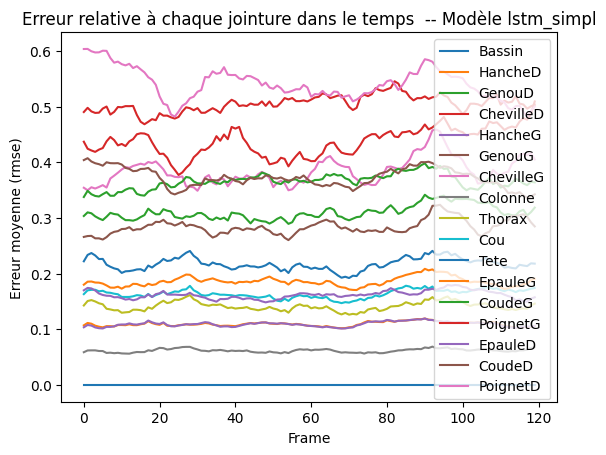

In [12]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps  -- Modèle lstm_simpl")
plt.legend()
plt.show()

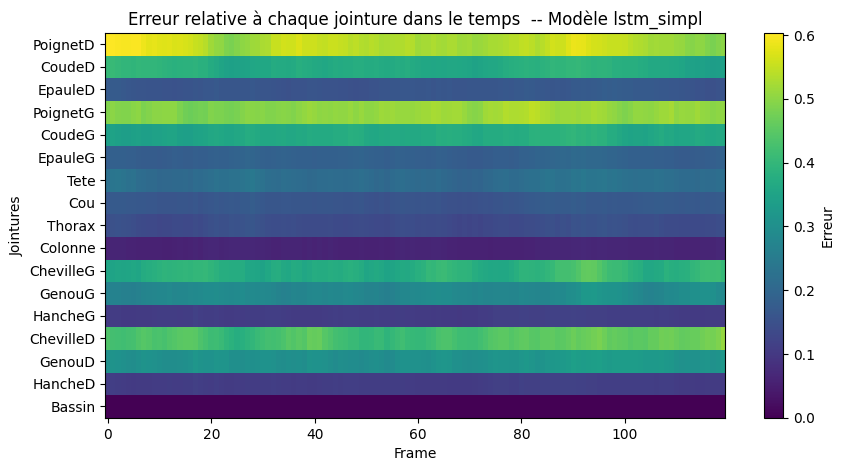

In [13]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps  -- Modèle lstm_simpl")
plt.show()

Et en moyenne sur les jointures :

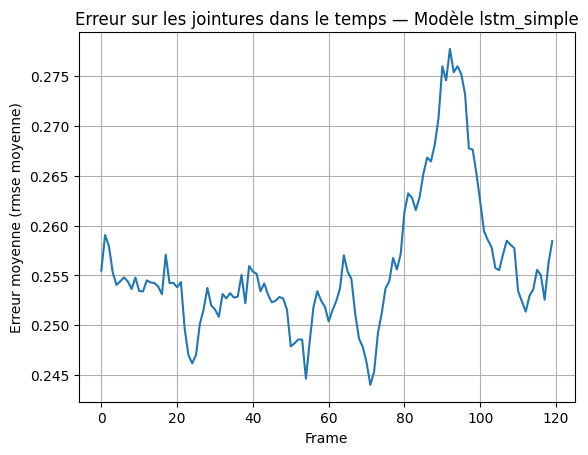

In [14]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur sur les jointures dans le temps — Modèle lstm_simple")
plt.grid()
plt.show()

#### Et sur les os :

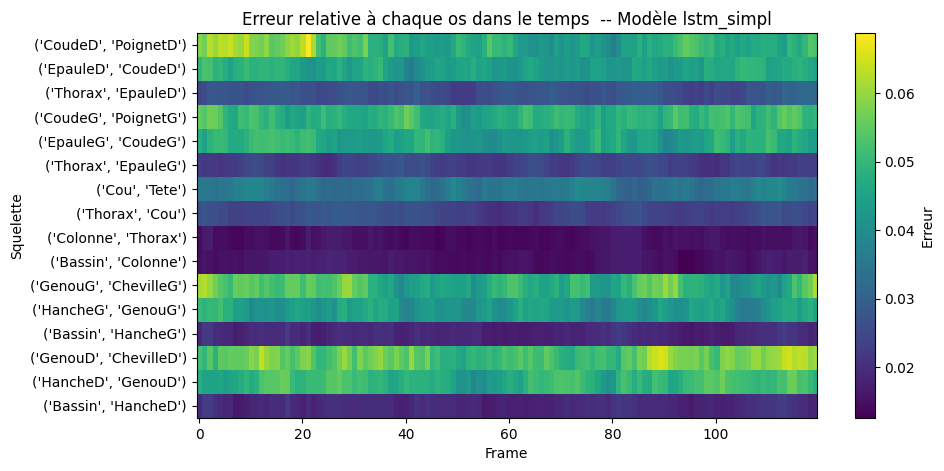

In [15]:
plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps  -- Modèle lstm_simpl")
plt.show()

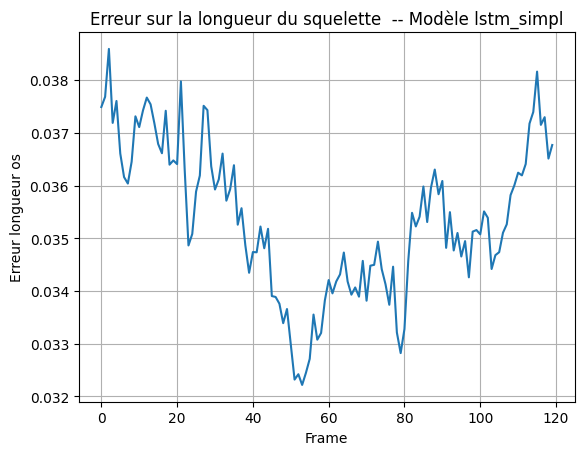

In [16]:
bone_time = mean_bone_lenght_err.mean(axis=1)

plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur moyenne sur la longueur des os  -- Modèle lstm_simpl")
plt.grid(True)
plt.show()

Globalement, pour chacunes des deux erreurs, nous avons un résultat proche d'un simple bruit, avec des valeurs ocillant entre 0.2 et 0.3 pour les jointures, et entre 0.033 et 0.038 pour les os.
### En Auto-régression

In [17]:
# la moyenne de tous les échantillons : 
NB_FRAME = 80
NB_SEQ = 20

mean_rmse = np.zeros(())
mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for seq in test[:NB_SEQ] :
    X = seq
    Y_true = X[WINDOW_SIZE:WINDOW_SIZE+NB_FRAME]

    input = X[:WINDOW_SIZE].reshape(WINDOW_SIZE, -1)
    input = (input - MEAN_POS) / STD_POS

    Y_pred = auto_pred(lstm_simple, input, NB_FRAME)
    Y_pred = inverse_lstm_output(Y_pred)

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y_true[:T] - Y_pred[:T], axis=-1) 
    bone_err = bone_lenght_error(Y_true[:T], Y_pred[:T])

    mean_rmse_per_joint[:T] += joint_err
    mean_bone_lenght_err[:T] += bone_err


mean_rmse_per_joint /= len(test[:NB_SEQ])
mean_bone_lenght_err /= len(test[:NB_SEQ])

#### Sur les jointures

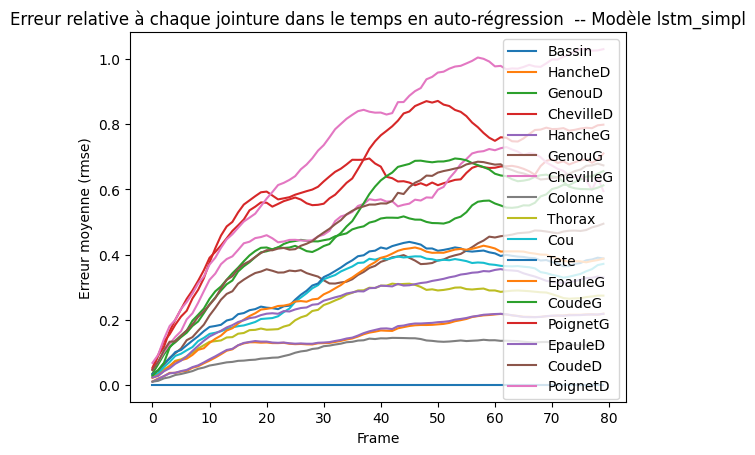

In [18]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps en auto-régression  -- Modèle lstm_simpl")
plt.legend()
plt.show()

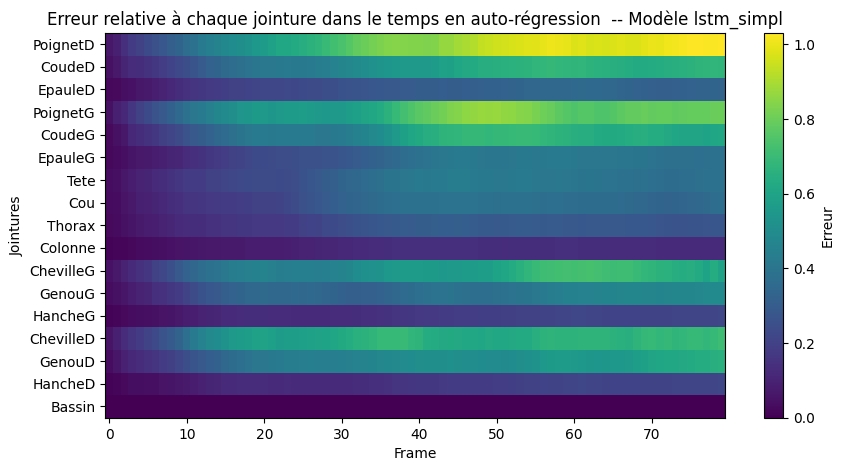

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps en auto-régression  -- Modèle lstm_simpl")
plt.show()

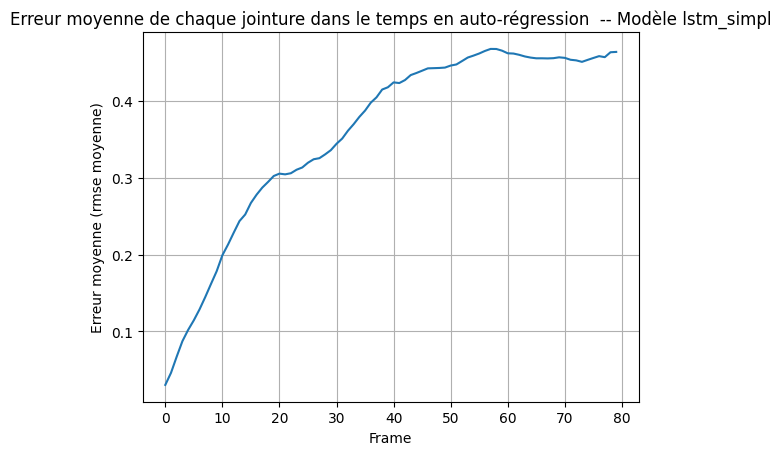

In [20]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur moyenne de chaque jointure dans le temps en auto-régression  -- Modèle lstm_simpl")
plt.grid()
plt.show()

#### Et sur les os :

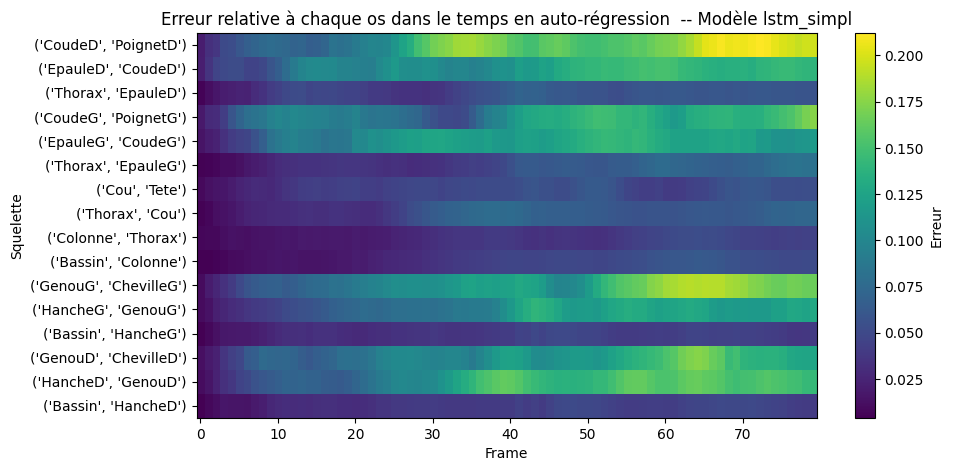

In [21]:

plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps en auto-régression  -- Modèle lstm_simpl")
plt.show()

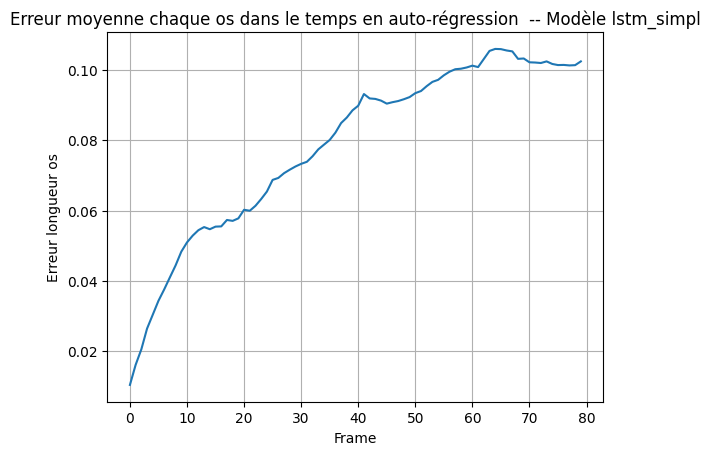

In [22]:
bone_time = mean_bone_lenght_err.mean(axis=1)

plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur sur la longueur des os en auto-régression -- Modèle lstm_simpl")
plt.grid(True)
plt.show()

In [23]:
del lstm_simple

On peut constater qu'en auto régression le modèle s'en sort beaucoup moins bien, l'erreur semble grandir de manière logarithmique, avec une forte croissance sur les première frames obtenues.

## Modèle n°2

Passons maintenant au deuxième modèle :

In [74]:
conv_lstm = load_model(MODEL_PATH+"conv_lstm.keras")
conv_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 510)            │        65,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 51)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,316 (3.21 MB)

 Trainable params: 279,934 (1.07 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 559,870 (2.14 MB)

In [75]:
HORIZON = 10
WINDOW_SIZE = 30
NB_FEATURES = len(JOINTURES)*3

test_vel = [compute_velocity(seq) for seq in test]

def compute_position(
    vel_seq: PointSequence, star_pos: np.ndarray, bassin_en_zero=True
) -> PointSequence:
    T = vel_seq.shape[0]
    poses = np.zeros((T, 17, 3))

    poses[0] = star_pos + vel_seq[0]

    if bassin_en_zero:
        poses[0, 0] = 0
        
    for t in range(1, T):
        poses[t] = poses[t - 1] + vel_seq[t]

        if bassin_en_zero:
            poses[t, 0] = 0
    return poses

def make_data_for_conv_lstm(data: list[PointSequence], window=WINDOW_SIZE, horizon=HORIZON):
    X_all, Y_all = [], []

    for seq in data:
        for i in range(len(seq) - window - horizon):
            X_all.append(seq[i:i+window])
            Y_all.append(seq[i + window : i + window + horizon])

    X_all = np.array(X_all)
    Y_all = np.array(Y_all)

    X_all = X_all.reshape(X_all.shape[0], window, -1)
    Y_all = Y_all.reshape(Y_all.shape[0], horizon, -1)

    # Normalisation
    X_all = (X_all - MEAN_VEL) / STD_VEL
    Y_all = (Y_all - MEAN_VEL) / STD_VEL

    return X_all, Y_all


def inverse_conv_lstm_output(pred):
    pred = pred*STD_VEL+MEAN_VEL
    return pred.reshape(pred.shape[0], HORIZON, 17,3)



In [76]:
def auto_pred_horizon(model, input, nb_frame):
    window = input.copy()
    preds = []

    while len(preds) < nb_frame:
        y = model.predict(window[None], verbose=0)[0]
        preds.extend(y)

        window = np.vstack([window[HORIZON:], y])

    return np.array(preds[:nb_frame])


Mesurons à quel point notre modèle mesure corectement la frame suivante :  
(`HORIZON` frames)

### En prédiction simple (sans auto-régression)

In [77]:
# la moyenne de tous les échantillons : 
NB_FRAME = 120

mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for (seq,seq_vel) in zip(test, test_vel):
    Y = seq[:NB_FRAME+WINDOW_SIZE]
    P0 = Y[0]
    Y_v = seq_vel[:NB_FRAME+WINDOW_SIZE]

    X,_ = make_data_for_conv_lstm([Y_v])
    
    Y_pred_v_blocks = inverse_conv_lstm_output(conv_lstm.predict(X, verbose=0))

    Y_pred = np.vstack(Y_pred_v_blocks)[:NB_FRAME]

    Y_pred = compute_position(Y_pred, P0)

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y[:T] - Y_pred[:T], axis=-1)
    mean_rmse_per_joint[:T] += joint_err

    bone_err = bone_lenght_error(Y[:T], Y_pred[:T])
    mean_bone_lenght_err[:T] += bone_err


mean_rmse_per_joint /= len(test)
mean_bone_lenght_err /= len(test)

#### Sur les jointures

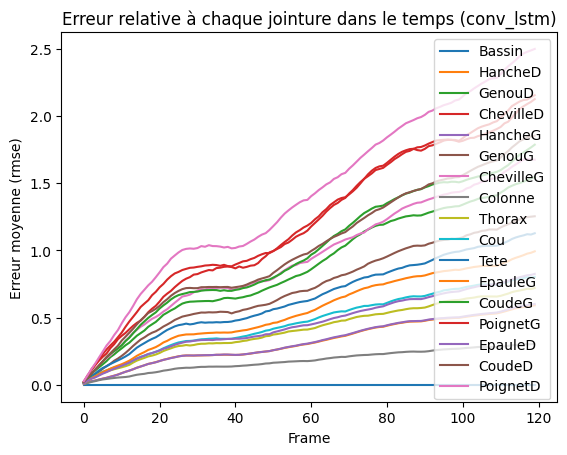

In [78]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps (conv_lstm)")
plt.legend()
plt.show()

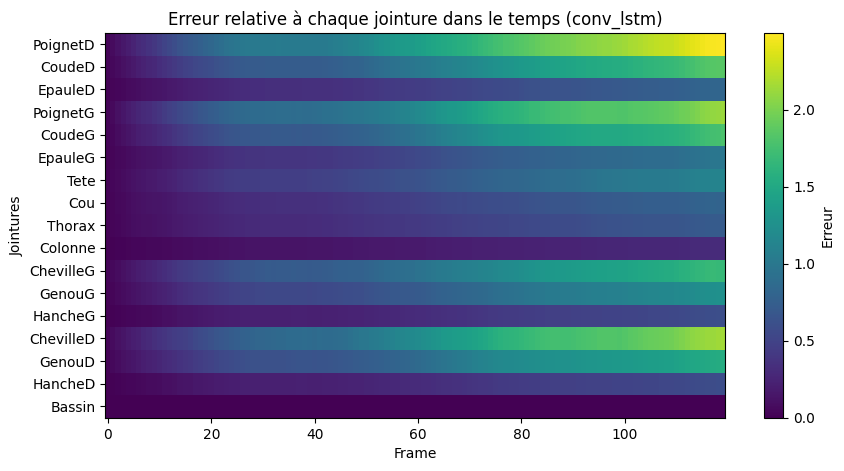

In [79]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps (conv_lstm)")
plt.show()

Et en moyenne sur les jointures :

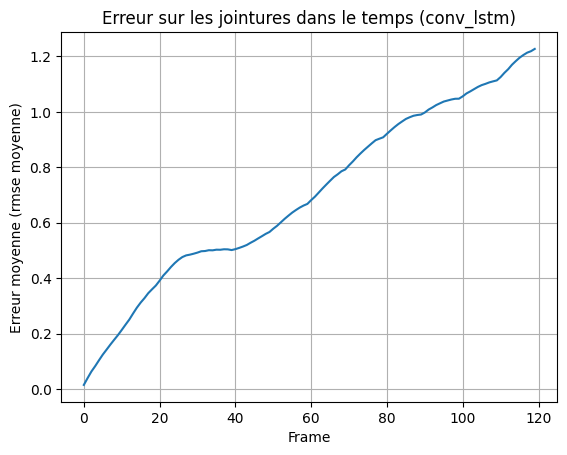

In [80]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur sur les jointures dans le temps (conv_lstm)")
plt.grid()
plt.show()

#### Et sur les os :

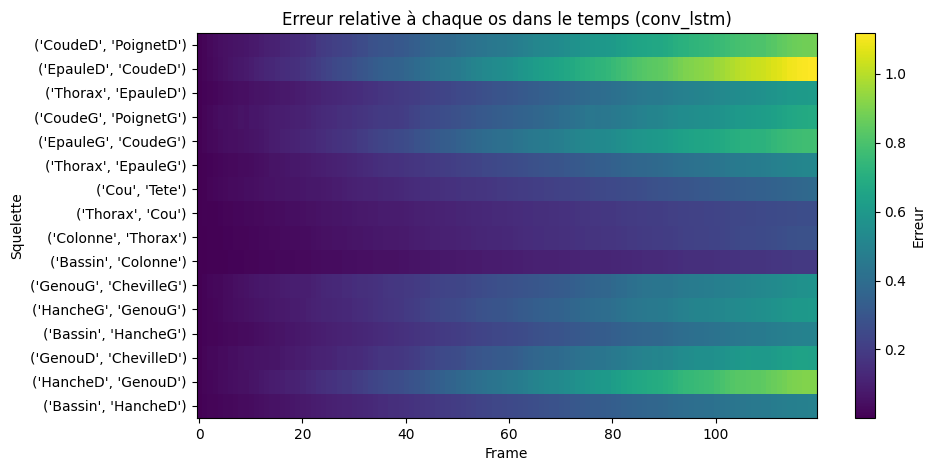

In [81]:
plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps (conv_lstm)")
plt.show()

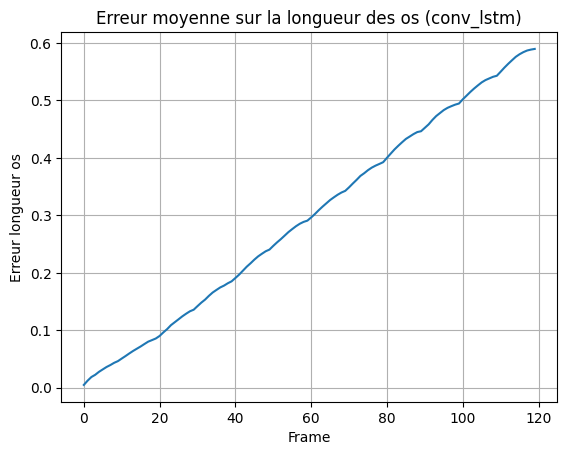

In [82]:
bone_time = mean_bone_lenght_err.mean(axis=1)

plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur moyenne sur la longueur des os (conv_lstm)")
plt.grid(True)
plt.show()

Du au caractère d'accumulation de la vitesse, ce modèle prédit moins bien dans le temps, avec une erreur quasiment linéaire sur les jointures comme sur les os.  

### En Auto-régression


In [83]:
# la moyenne de tous les échantillons : 
NB_FRAME = 120
NB_SEQ = 20

mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for seq in test[:NB_SEQ] :
    curr_vel = seq_vel[:WINDOW_SIZE].copy()
    P0 = seq[:WINDOW_SIZE][0]
    preds_vel = []

    while len(preds_vel) < NB_FRAME:
        X = curr_vel.reshape(1,WINDOW_SIZE, -1)
        X = (X-MEAN_VEL) / STD_VEL

        Y_pred_n = conv_lstm.predict(X, verbose=0)
        Y_pred_vel = inverse_conv_lstm_output(Y_pred_n)[0]

        preds_vel.extend(Y_pred_vel)

        curr_vel = np.vstack([curr_vel[HORIZON:], Y_pred_vel])

    preds_vel = np.array(preds_vel[:NB_FRAME])

    Y_pred = compute_position(preds_vel, P0)
    Y_true = seq[WINDOW_SIZE: WINDOW_SIZE+NB_FRAME]

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y_true[:T] - Y_pred[:T], axis=-1)
    mean_rmse_per_joint[:T] += joint_err

    # Erreur os
    bone_err = bone_lenght_error(Y_true[:T], Y_pred[:T])
    mean_bone_lenght_err[:T] += bone_err


mean_rmse_per_joint /= len(test[:NB_SEQ])
mean_bone_lenght_err /= len(test[:NB_SEQ])

#### Sur les jointures

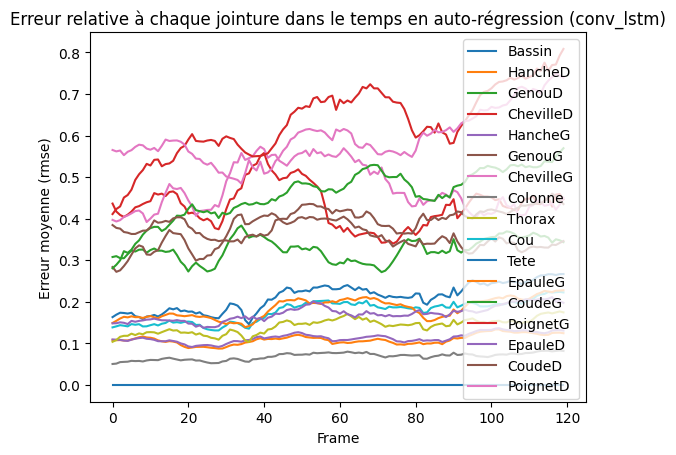

In [84]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps en auto-régression (conv_lstm)")
plt.legend()
plt.show()

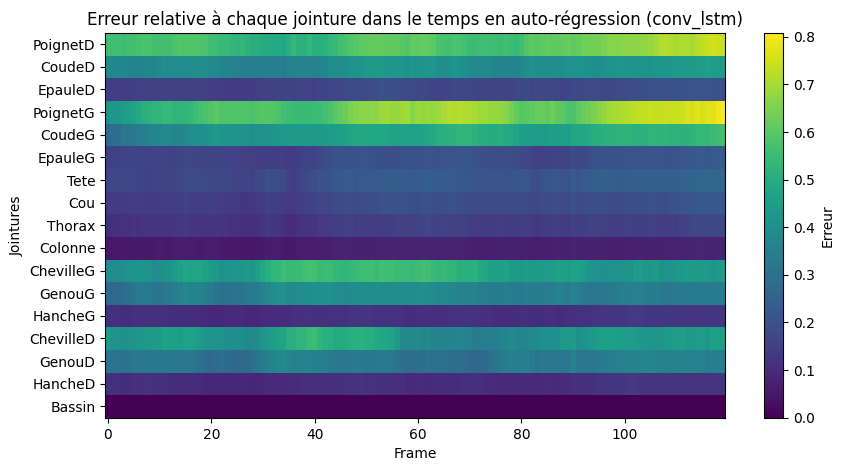

In [85]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps en auto-régression (conv_lstm)")
plt.show()

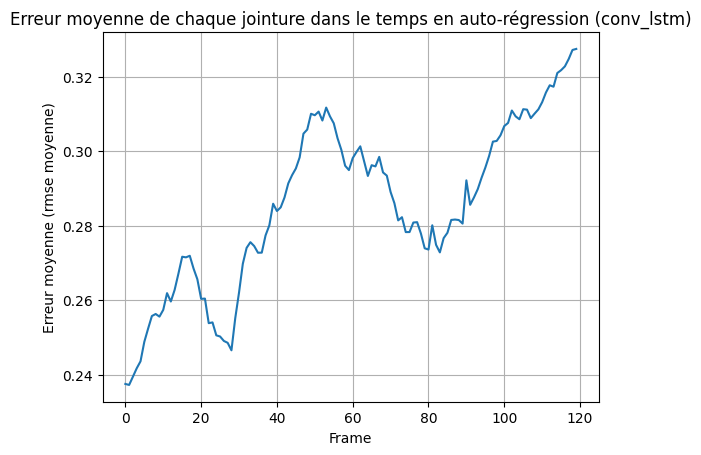

In [86]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur moyenne de chaque jointure dans le temps en auto-régression (conv_lstm)")
plt.grid()
plt.show()

#### Et sur les os :

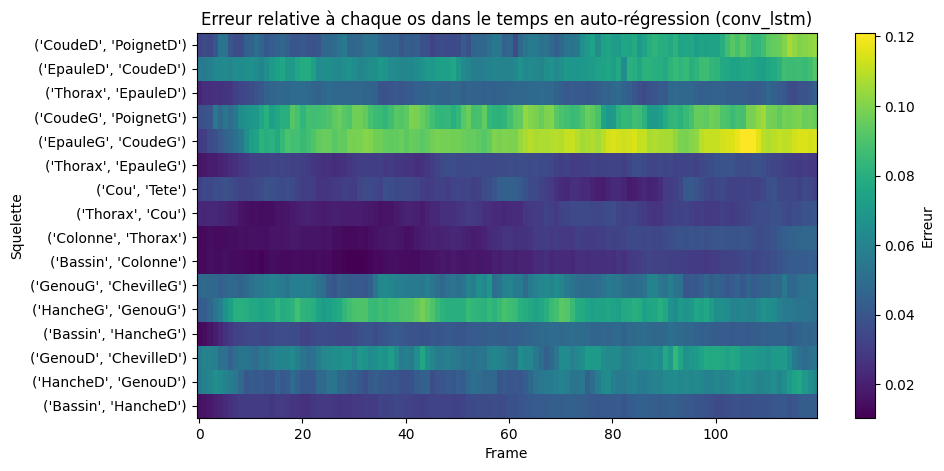

In [87]:
plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps en auto-régression (conv_lstm)")
plt.show()

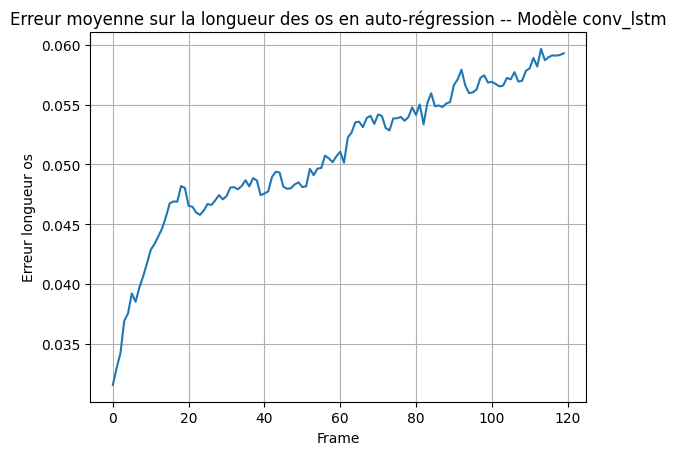

In [88]:
bone_time = mean_bone_lenght_err.mean(axis=1)

plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur moyenne sur la longueur des os en auto-régression -- Modèle conv_lstm")
plt.grid(True)
plt.show()

In [89]:
del conv_lstm

Malgrès le faite que se modèle prédisent moins bien que le dernier sans auto-régression, ce dernier s'en sort beaucoup mieux en auto-régression, avec une erreur comprise entre 0.22 et 0.3 sur les jointures et 0.033 et 0.065 sur les os.
On peut aussi noter l'impacte de la génération de `HORIZON` frames d'un coup, on voit une périodicité se générer.

## Modèle n°3 (dernier modèle)


In [40]:
HORIZON = 10
WINDOW_SIZE = 30
NB_FEATURES = len(JOINTURES)*6

#redéfinition des loss
def bone_length_loss(skeleton):
    def loss(y_true, y_pred):

        y_true = tf.reshape(y_true, (-1, tf.shape(y_true)[1], 17, 3))
        y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[1], 17, 3))

        bone_loss = 0.0

        for i, j in skeleton:
            true_len = tf.norm(
                y_true[:, :, i] - y_true[:, :, j],
                axis=-1
            )
            pred_len = tf.norm(
                y_pred[:, :, i] - y_pred[:, :, j],
                axis=-1
            )
            bone_loss += tf.reduce_mean(tf.square(pred_len - true_len))

        return bone_loss / len(skeleton)

    return loss

def smooth_vel_loss(horizon=HORIZON):
    def loss(_y_true, y_pred):
        yp = tf.reshape(y_pred, (-1, horizon, 17, 3))
        vel = yp[:,1:] - yp[:,:-1]
        return tf.reduce_mean(tf.square(vel))
    
    return loss

def total_loss(skeleton, base_loss = tf.losses.mse, bone_loss_w= 0.05, smooth_loss_w= 0.01, horizon=HORIZON):
    bone_loss = bone_length_loss(skeleton)
    smooth_loss = smooth_vel_loss(horizon=horizon)
    def loss(y_true, y_pred):
        return base_loss(y_true, y_pred) + bone_loss_w * bone_loss(y_true, y_pred) + smooth_loss_w* smooth_loss(y_true, y_pred)
    return loss

In [41]:
# Chargement du modèle :
model_pos_vel = load_model(
    MODEL_PATH+"model_pos_vel.keras",
    custom_objects={
        "loss": total_loss(
            SQUELETTE,
        )
    }
)

model_pos_vel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 26, 128)        │        65,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10, 51)         │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,144,091 (11.99 MB)

 Trainable params: 1,047,859 (4.00 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2,095,720 (7.99 MB)

In [42]:
def make_data_for_pos_vel(data_pos: list[PointSequence] , window=WINDOW_SIZE, horizon=HORIZON):
    X_all, Y_all = [],[]

    for pos_seq in data_pos:
        # calcule de la vitesse localement
        vel_seq = np.zeros_like(pos_seq)
        vel_seq[1:] = pos_seq[1:] - pos_seq[:-1]

        #normalisation
        pos_norm = (pos_seq-MEAN_POS_3D) / STD_POS_3D
        vel_norm = (vel_seq-MEAN_VEL_3D) / STD_VEL_3D

        # concatenation
        pos_vel = np.concatenate([pos_norm, vel_norm], axis=-1) 
        
        #création de la fenêtre
        for i in range(len(pos_vel) - window - horizon):
            X_all.append(pos_vel[i : i + window])
            Y_all.append(pos_norm[i + window : i + window + horizon, :])



    return np.array(X_all).reshape(-1, window, NB_FEATURES), \
           np.array(Y_all).reshape(-1, horizon, 17*3)

    

def inverse_pos_vel_output(pred_norm):
    pred = np.array(pred_norm)

    if pred.ndim == 3:
        B, H, F = pred.shape
        pred = pred.reshape(B * H, F)
    elif pred.ndim == 2:
        pass

    # dénormalisation pos
    pred = pred * STD_POS + MEAN_POS

    # reshape en squelette
    pred = pred.reshape(pred.shape[0], 17, 3)

    return pred

def auto_pred_pos_vel(model, seq_pos, nb_frames,
                      window=WINDOW_SIZE, horizon=HORIZON):

    curr_pos = seq_pos[:window].copy()
    preds = []
    
    while len(preds)<nb_frames:
        # calcule de la vitesse localement
        vel_seq = np.zeros_like(curr_pos)
        vel_seq[1:] = curr_pos[1:] - curr_pos[:-1]

        # normalisation
        pos_n = (curr_pos - MEAN_POS_3D) / STD_POS_3D
        vel_n = (vel_seq - MEAN_VEL_3D) / STD_VEL_3D

        X = np.concatenate([pos_n, vel_n], axis=-1).reshape(1, WINDOW_SIZE, -1)

        # on fait la prédiction
        Y_norm = model.predict(X, verbose=0)[0]

        #dénormalisation de la prédiction
        Y = Y_norm.reshape(horizon, 17, 3)
        Y = Y * STD_POS_3D + MEAN_POS_3D

        # màj des predictions
        for f in range(horizon):
            preds.append(Y[f])

        curr_pos = np.vstack([curr_pos[horizon:], Y])
    
    return np.array(preds[:nb_frames])

Mesurons à quel point notre modèle mesure corectement les frames suivante :  
(`HORIZON` frames)  
### En prédiction simple (sans auto-régression)

In [43]:
NB_FRAME = 120
NB_SEQ = 20

mean_rmse_per_joint = mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for seq in test[:NB_SEQ]:
    Y = seq[:NB_FRAME + WINDOW_SIZE]

    X, _ = make_data_for_pos_vel([Y])

    Y_pred_n = model_pos_vel.predict(X, verbose=0)
    Y_pred = inverse_pos_vel_output(Y_pred_n)

    Y_true = Y[WINDOW_SIZE:WINDOW_SIZE+len(Y_pred)]

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y_true[:T] - Y_pred[:T], axis=-1)
    mean_rmse_per_joint[:T] += joint_err

    bone_err = bone_lenght_error(Y_true[:T], Y_pred[:T])
    mean_bone_lenght_err[:T] += bone_err

mean_rmse_per_joint /= len(test[:NB_SEQ])
mean_bone_lenght_err /= len(test[:NB_SEQ])

#### Sur les jointures

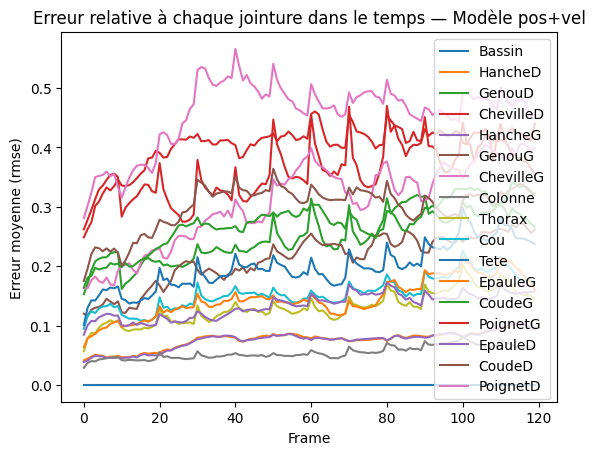

In [44]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps — Modèle pos+vel")
plt.legend()
plt.show()

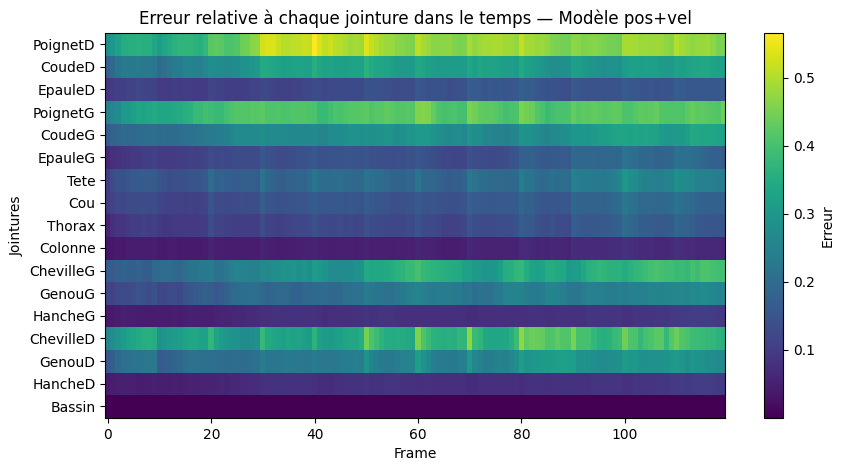

In [45]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps — Modèle pos+vel")
plt.show()

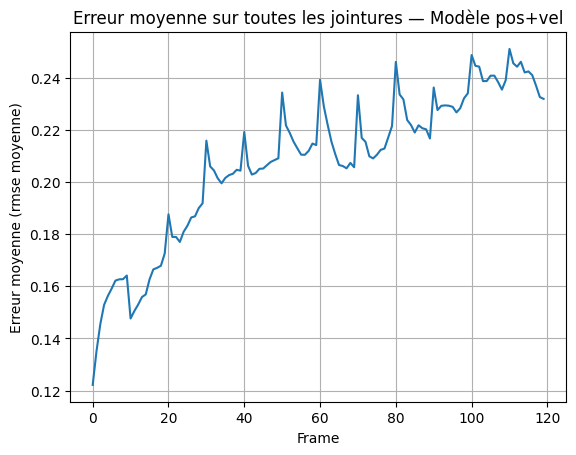

In [46]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur moyenne sur toutes les jointures — Modèle pos+vel")
plt.grid()
plt.show()

#### Et sur les os

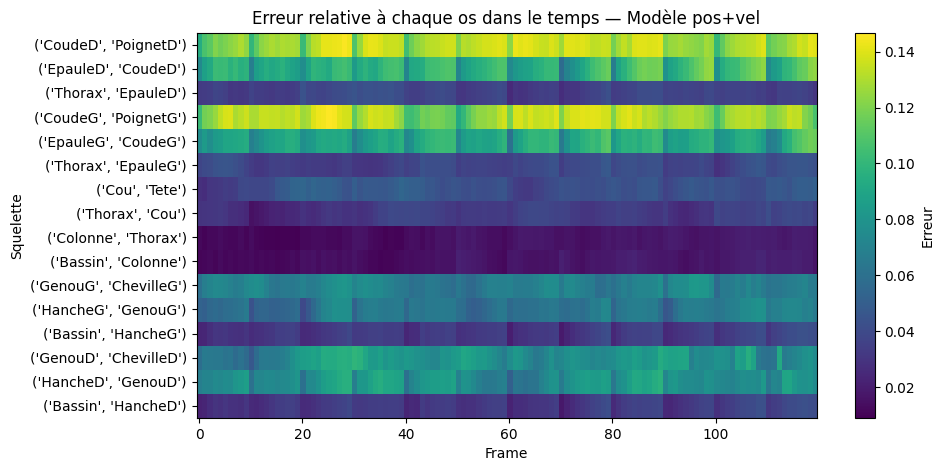

In [47]:
plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps — Modèle pos+vel")
plt.show()

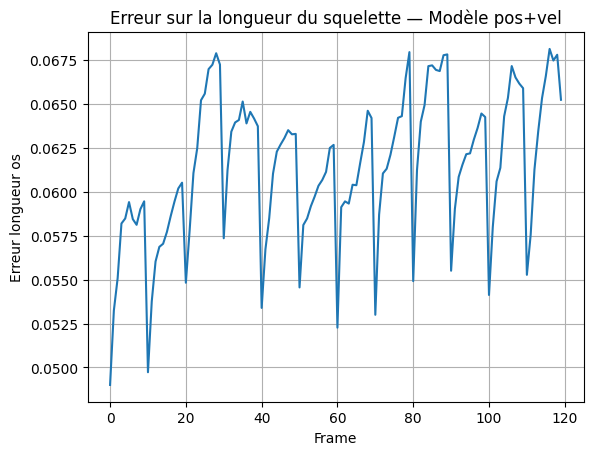

In [48]:
bone_time = mean_bone_lenght_err.mean(axis=1)
plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur moyenne sur la longueur des os — Modèle pos+vel")
plt.grid(True)
plt.show()


Ce modèle prédit relativement bien les prochaines frames sans auto-régression, avec de meilleur résultats sur les erreurs par jointures, mais de moins bon résultats sur les erreurs par os, malgrès la loss qui prends ces derniers en compte.

### En auto-régression

In [49]:
NB_FRAME = 120
NB_SEQ = 20

mean_rmse_per_joint = np.zeros((NB_FRAME, 17))
mean_bone_lenght_err = np.zeros((NB_FRAME, len(SQUELETTE)))

for seq in test[:NB_SEQ] :
    X = seq
    Y_true = X[WINDOW_SIZE:WINDOW_SIZE+NB_FRAME]

    Y_pred = auto_pred_pos_vel(model_pos_vel, X, NB_FRAME)

    T = min(len(Y_pred), NB_FRAME)

    joint_err = np.linalg.norm(Y_true[:T] - Y_pred[:T], axis=-1) 
    bone_err = bone_lenght_error(Y_true[:T], Y_pred[:T])

    mean_rmse_per_joint[:T] += joint_err
    mean_bone_lenght_err[:T] += bone_err


mean_rmse_per_joint /= len(test[:NB_SEQ])
mean_bone_lenght_err /= len(test[:NB_SEQ])
    

#### Sur les jointures

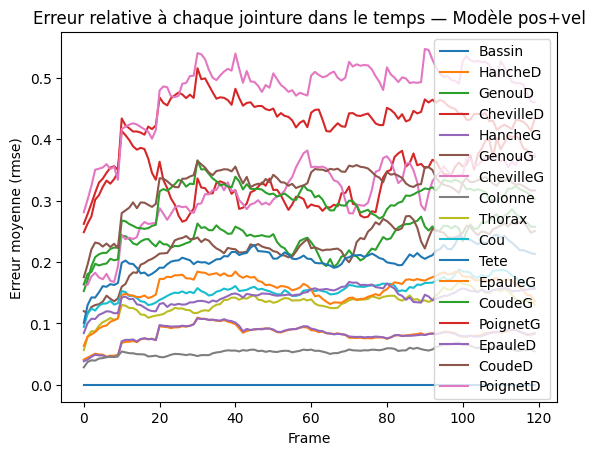

In [50]:
for i in range(NB_JOINTURES):
    plt.plot(mean_rmse_per_joint[:,i], label=JOINTURES[i])
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse)")
plt.title("Erreur relative à chaque jointure dans le temps — Modèle pos+vel")
plt.legend()
plt.show()

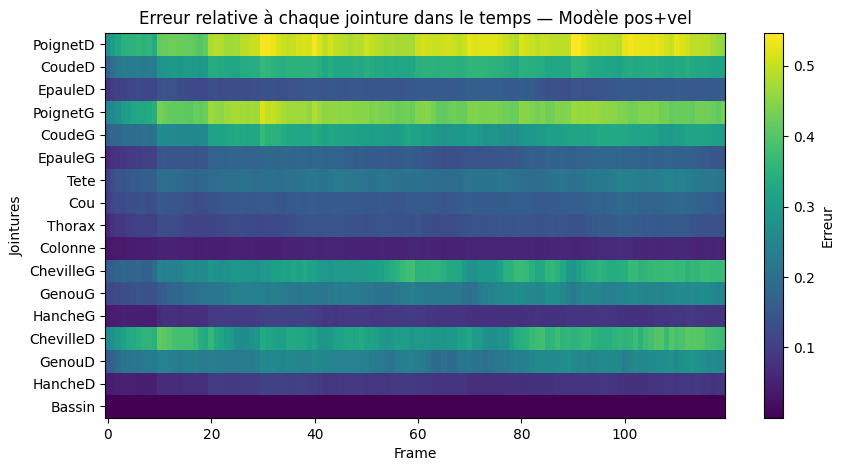

In [51]:
plt.figure(figsize=(10,5))
plt.imshow(mean_rmse_per_joint.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
plt.yticks(range(17), JOINTURES)
plt.xlabel("Frame")
plt.ylabel("Jointures")
plt.title("Erreur relative à chaque jointure dans le temps — Modèle pos+vel")
plt.show()

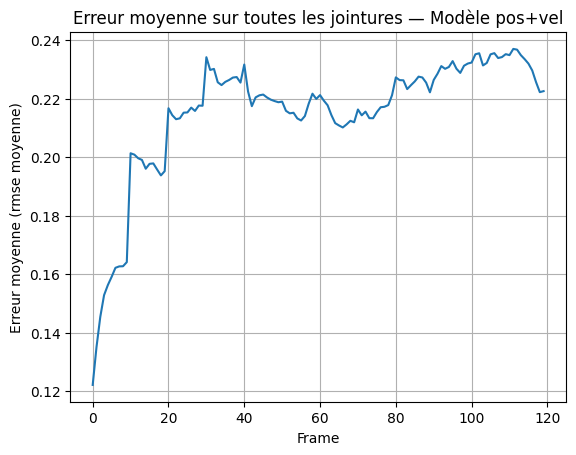

In [52]:
mean_joint_err = mean_rmse_per_joint.mean(axis=1)
plt.figure()
plt.plot(mean_joint_err)
plt.xlabel("Frame")
plt.ylabel("Erreur moyenne (rmse moyenne)")
plt.title("Erreur moyenne sur toutes les jointures — Modèle pos+vel")
plt.grid()
plt.show()

#### Et sur les os :

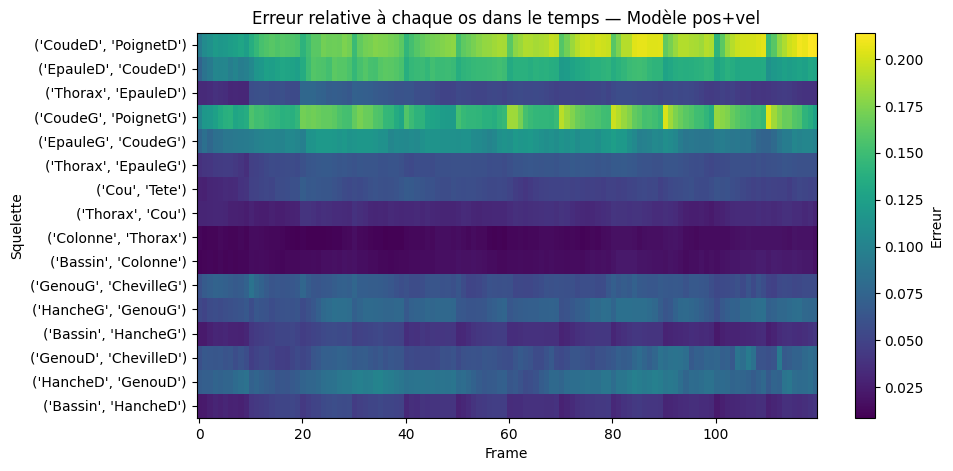

In [53]:
plt.figure(figsize=(10,5))
plt.imshow(mean_bone_lenght_err.T, aspect="auto", origin="lower")
plt.colorbar(label="Erreur")
labels = [str((JOINTURES[i], JOINTURES[j])) for i,j in SQUELETTE]
plt.yticks(range(len(SQUELETTE)), labels)
plt.xlabel("Frame")
plt.ylabel("Squelette")
plt.title("Erreur relative à chaque os dans le temps — Modèle pos+vel")
plt.show()

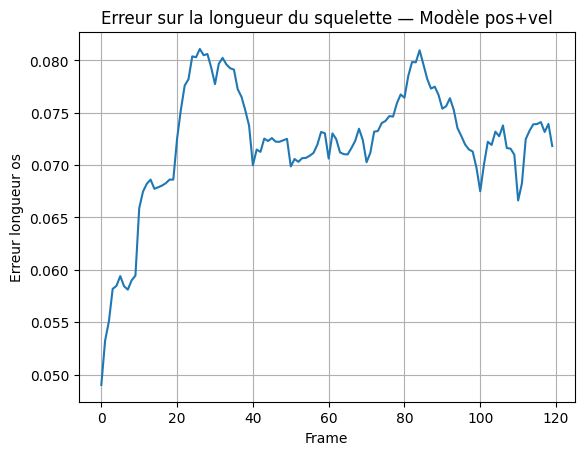

In [54]:
bone_time = mean_bone_lenght_err.mean(axis=1)
plt.plot(bone_time)
plt.xlabel("Frame")
plt.ylabel("Erreur longueur os")
plt.title("Erreur sur la longueur des os en auto-régression — Modèle pos+vel")
plt.grid(True)
plt.show()


In [55]:
del model_pos_vel

Finalement ce dernier modèle performe bien, on voit une nette amélioration par rapport au deux premiers modèles, mais il faut noter que ce dernier est beaucoup plus couteux à entrainer, et notament, très demandant en mémoire vive, du à sa taille, et au données d'entrer qui sont doublées en input.

On peut toujours voir des "cassure" comme pour le deuxième modèle, du à la génération de `HORIZON` frames à la fois, mais l'effet est beaucoup moindre.

Malgrès la loss, qui prend en compte la longueur des os, le modèle a une errreur plus forte sur ce critére, mais plus stable dans le temps.  
Peut être faut-il augmenter le poids de la loss associée, ou changer l'implémentation.  